In [1]:
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def inverse_sample_decorator(dist):
    def wrapper(pnts, x_min=-100, x_max=100, n=1e5, **kwargs):
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        real_low = (cumulative/cumulative.max()).min()
        real_high = (cumulative/cumulative.max()).max()
        #print((cumulative/cumulative.max()).max(),(cumulative/cumulative.max()).min())
        f = interp1d(cumulative/cumulative.max(), x)
        return f(np.random.uniform(low=real_low, high=real_high, size=pnts))
    return wrapper

In [3]:
# First trying sampling from a simple gaussian distribution
@inverse_sample_decorator
def gauss(x, amp=1.0, mean=0.0, std=0.2):
    return amp*np.exp(-(x-mean)**2/std**2/2.0)

In [4]:
samples = gauss(5000, mean=20, std=0.8, x_min=19, x_max=21)

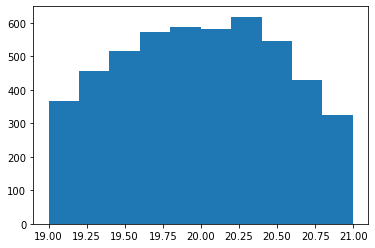

In [5]:
plt.hist(samples)
plt.show()

In [6]:
# Experimenting with Eq2
@inverse_sample_decorator
def f(x,ts=[1.1,1.2,1.3,1.4]):
    xx = x/(13)**0.5
    v = ts[0] * ((1-xx)**(ts[1])) * (xx**ts[2]) * (xx**(ts[3]*np.log(xx)))
    return v

In [7]:
sampless = f(500000,ts=[1.1,1.2,1.3,1.4],x_min=1/(13**0.5),x_max=7/(13**0.5))

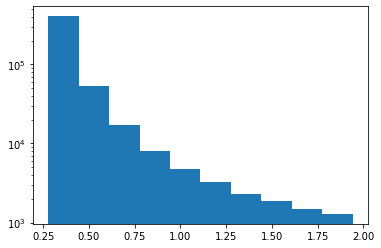

In [8]:
plt.hist(sampless, log=True)
plt.show()

[1.67361557 1.45590023 1.31151048 1.34646715]
[2.58639561 1.94080801 2.27563027 2.0810395 ]
[3.45548968 2.36720188 3.27468053 3.18549531]
[4.6543067  3.17407818 2.68326863 2.68969741]
[3.78553601 5.97306201 3.40106812 3.83673211]
[5.69609838 5.96124807 6.0758972  5.31492755]


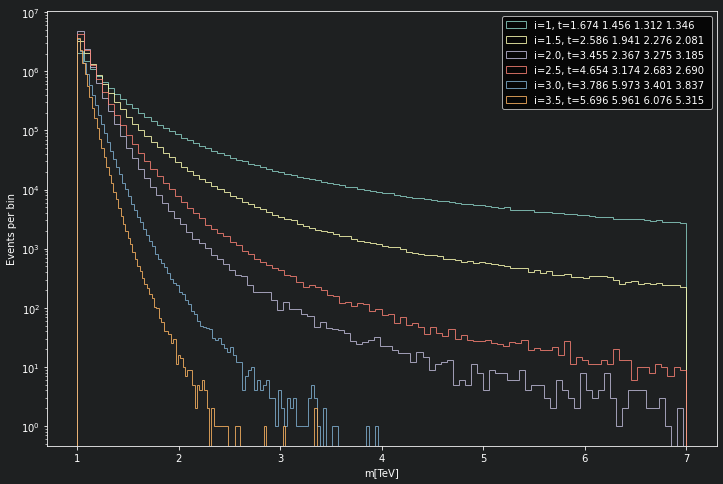

In [9]:
# Varing the theta values
# not sure the range that makes sense
plt.style.use("dark_background")
plt.figure(figsize=(12,8), facecolor='#1e2021')
ax = plt.gca()
ax.set_facecolor('#1e2021')
i = 1
while i != 4:
    tsx = i * np.random.uniform(low=1, high=2, size=4)
    print(tsx)
    strFormat = len(tsx) * '{:.3f} '
    ftsx = strFormat.format(*tsx)
    samplex = f(10000000,ts=tsx,x_min=1/(13**0.5),x_max=7/(13**0.5)) 
    samplex *= (13**0.5)
    plt.hist(samplex, log=True, label="i={}, t={}".format(i,ftsx), histtype="step",
             alpha=0.8, bins=100)
    i += 0.5
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()